<a href="https://colab.research.google.com/github/ShihaoCui/18337/blob/master/Impulse_response_guided_wave_GA_inversion_long.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This is to install the package of Genegtic algorithm

In [ ]:
pip install scikit-opt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from dataclasses import dataclass    
from math import erfc  
from joblib import Parallel, delayed  
import json  
import numpy as np 
# from geondt import PoroSEM
from scipy.special import jv,jn_zeros
from scipy import special,optimize 
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt
from numpy.linalg import inv

# GW model

In [ ]:
"""
This module is used to perform dispersion analysis for a cylindrical pile. 
"""
from dataclasses import dataclass    
from math import erfc  
from joblib import Parallel, delayed  
import json  
import numpy as np 
# from geondt import PoroSEM
from scipy.special import jv,jn_zeros
from scipy import special,optimize 

@dataclass
class DPR:
    ''' 
    Object for the dispersion analysis of a cylindrical pile with a finite length L an a finite radius r

    :param fn: A mandatory (floating) vector that defines the given frequencies (Hz) which refers to the resonace frequency observed by the responses 
    :param E:    A mandatory (floating) scalar that defines the Young's modulus (Pa) of the test pile 
    :param vv:   A mandatory (floating) scalar that defines the Poisson's ratio of the test pile
    :param rho:  A mandatory (floating) scalar that defines the density (kg/m^3) for test pile
    :param r:  A mandatory (floating) scalar that defines the radius of the test pile
    :param m:  A mandatory (floating) scalar that defines the which mode would be used, where m = 0 longitudinal mode; m=1 flexural mode; m is defaluted as 0(longitudinal mode).
    :return:  Dispersion relations, i.e., the relation between the phase velocity and the given resonance frequencies
    ''' 
    
    def __init__(self, fn, E, rho, vv, r,m=0):
        self.fn = fn
        self.E = E
        self.rho = rho
        self.vv = vv
        self.r = r
        self.m = m

    def model_L(self, i): 
        ''' Define dispersion modelling and root searching algorithm for the longtudinal guided wave model for a cylinder waveguide(Pile)'''
                
        # Bessel functions at order 0, 1, and 2 of the 1st kind
        def J0(y):
            return sp.jv(0, y)
        def J1(y):
            return sp.jv(1, y)
        def J2(y):
            return sp.jv(2, y)
    
        def fun(k): 
            E = self.E
            rho  = self.rho
            vv = self.vv
            
            r = self.r
            
            cb = np.sqrt(E/rho) # bar velocity

        #     #lame coefficients
            nu = E/(2*(1+vv))
            lbd = E*vv/((1+vv)*(1-2*vv)) 

            cs = cb*np.sqrt(1/(2*(1+vv))) # shear wave speed
            cp = cb*np.sqrt((1-vv)/((1+vv)*(1-2*vv))) # longtudinal wave speed
        #     print(str(cs)+str("      ")+str(cp))

            ks = np.sqrt(np.complex(-k**2+(w**2)/(cs**2))) # the wavenumebr of the shear waves
            kp = np.sqrt(np.complex(-k**2+(w**2)/(cp**2))) # the wavenumber of the longitudinal waves

            M = np.zeros([2,2],dtype = complex)# the matrix of the disperison relation, |M|=0 is the spectrum relation
            M[0,0] = -(lbd*k**2+lbd*kp**2+2*nu*kp**2)*J0(kp*r)+2*nu*kp*J1(kp*r)/r
            M[0,1] = -2*nu*1j*k*ks*J0(ks*r)+2*nu*1j*k*J1(ks*r)/r
            M[1,0] = -2*1j*nu*k*kp*J1(kp*r)
            M[1,1] = nu*(k**2-ks**2)*J1(ks*r)
    
            return np.linalg.det(M)/1e9
    
    
        w = i*2*np.pi # w omega: angular frequency
        incre = 1000 # initialization of the phase velocity
        root = 0.00001 # the initialization of the root
        step_length = 1 # the step length of the searching algorithm
        
        for j in range(10**6):
            past = incre
            val1 = fun(w/incre)
            incre =  incre + step_length
            val2 = fun(w/incre)
            if (np.real(val1) * np.real(val2) <= 0):
                root =  optimize.ridder(fun,w/incre,w/past) # the classical Ridders' algorithm
                break 
        return (w/root)     #give one value at a frequency 


    
    def model_F(self, i): 
        ''' Define dispersion modelling and root searching algorithm for the flexural guided wave model for a cylinder waveguide(Pile)'''
                
        # Bessel functions at order 0, 1, and 2 of the 1st kind
        def J0(y):
            return sp.jv(0, y)
        def J1(y):
            return sp.jv(1, y)
        def J2(y):
            return sp.jv(2, y)
    
        def fun(k): 
            E = self.E
            rho  = self.rho
            vv = self.vv
            
            r = self.r
            
            cb = np.sqrt(E/rho) # bar velocity

        #     #lame coefficients
            nu = E/(2*(1+vv))
            lbd = E*vv/((1+vv)*(1-2*vv)) 

            cs = cb*np.sqrt(1/(2*(1+vv))) # shear wave speed
            cp = cb*np.sqrt((1-vv)/((1+vv)*(1-2*vv))) # longtudinal wave speed
        #     print(str(cs)+str("      ")+str(cp))

            ks = np.sqrt(np.complex(-k**2+(w**2)/(cs**2))) # the wavenumebr of the shear waves
            kp = np.sqrt(np.complex(-k**2+(w**2)/(cp**2))) # the wavenumber of the longitudinal waves

            M = np.zeros([3,3],dtype = complex) # the matrix of the disperison relation, |M|=0 is the spectrum relation
            M[0,0] =  (-2*kp*r*nu*J0(kp*r)-(-4*nu+r**2*(k**2*lbd+kp**2*(lbd+2*nu)))*J1(kp*r))/(r**2)
            M[0,1] = -(2*ks*nu*J2(ks*r))/r
            M[0,2] =  (2*1j*k*nu*(2*ks*r*J0(ks*r)+(-4+ks**2*r**2)*J1(ks*r)))/(ks*r**2)
            M[1,0] =  (2*kp*nu*J2(kp*r))/r
            M[1,1] =  nu*(2*ks*r*J0(ks*r)+(-4+ks**2*r**2)*J1(ks*r))/r**2
            M[1,2] =  1j*k*nu*(4*ks*r*J0(ks*r)+(-8+ks**2*r**2)*J1(ks*r))/(ks*r**2)
            M[2,0] =  2*1j*k*nu*(kp*r*J0(kp*r)-J1(kp*r))/r
            M[2,1] =  1j*k*nu*J1(ks*r)/r
            M[2,2] = -0.5*nu*(ks**2*J0(ks*r)+(2*k**2-ks**2)*J2(ks*r))
    
            return np.linalg.det(M)/1e9
    
    
        w = i*2*np.pi # w omega: angular frequency
        incre = 5 # initialization of the phase velocity
        root = 0.00001 # the initialization of the root
        step_length = 1 # the step length of the searching algorithm
        
        for j in range(10**6):
            past = incre
            val1 = fun(w/incre)
            incre =  incre + step_length
            val2 = fun(w/incre)
            if (np.real(val1) * np.real(val2) <= 0):
                root =  optimize.ridder(fun,w/incre,w/past) # the classical Ridders' algorithm
                break 
        return (w/root)     #give one value at a frequency 

    def run(self):
        ''' Define function to be used for the Parallel computing'''
        omega = np.array(self.fn) # fn is the given input frequency (Hz) vector
        root_all = [] # the result of the phase velocity by the theoretical model corresponding to the give frequency vector (fn)
        for i in range(len(fn)):
          if self.m ==0:
            root_all.append(self.model_L(omega[i]))
          elif self.m == 1:
            root_all.append(self.model_F(omega[i]))
          else:
            print("Input error; m should be either o or 1; m=0 indicating longitudinal mode,m=1 indicating flexural mode; ")
        return np.array(root_all) 

## Function of error display

In [ ]:
def error_rate_fun(Real,Res_Est):
  V_error = (Real-Res_Est)/(Real)
  L_error = V_error[0]
  E_error = V_error[1]
  rho_error = V_error[2]
  vv_error = V_error[3]

  print("L_error",L_error)
  print("E_error",E_error)
  print("rho_error",rho_error)
  print("vv_error",vv_error)

  # The error of bar velocity
  Cb_error = (np.sqrt(Res_Est[1]/Res_Est[2])-np.sqrt(Real[1]/Real[2]))/(np.sqrt(Real[1]/Real[2]))
  print("bar velocity: Cb_error",Cb_error)

  # The error of shear velocity

  cb_est = np.sqrt(Res_Est[1]/Res_Est[2])
  cb_real = np.sqrt(Real[1]/Real[2])

  vv_est = Res_Est[3]
  vv_real = Real[3]

  cs_est = (cb_est)*np.sqrt((1-vv_est)/((1+vv_est)*(1-2*vv_est)))
  cs_real = (cb_real)*np.sqrt((1-vv_real)/((1+vv_real)*(1-2*vv_real)))

  cs_error  = (cs_est-cs_real)/cs_real
  cs_error
  print("shear velocity: cs_error",cs_error)

  # The error of longitudinal velocity

  cp_est = (cb_est)/np.sqrt(2*(1+vv_est))
  cp_real = (cb_real)/np.sqrt(2*(1+vv_real))

  cp_error  = (cp_est-cp_real)/cp_real
  cp_error
  print("longitudinal velocity: cp_error",cp_error)
  
  return None

## Expreiment data of the example using the longitudinal model

## Pile C

### observation data

In [ ]:
# Pile C
# experimental data: SC and DC BC respectively
F_res = np.array([419.52,804.79, 1190.07, 1566.78, 1986.30,2388.70, 2773.97,3184.93,3561.64,3981.16,4315.07, 4720.03, 5128.42])
n = np.linspace(1,F_res.shape[0],F_res.shape[0])
L = 4.829
C_ph_res_s = 2*L*F_res/(n-0.5)
C_ph_res_d = 2*L*F_res/(n)

NameError: ignored

In [ ]:
F_res.shape[0]

In [ ]:
n

In [ ]:
fn = F_res
E = 18773059558.275; # Young’s modulus
cb =3799
rho = E/cb**2;# density
print("rho",rho)
vv = 0.2 # poisson's ratio
r = 0.2/2
m = 0 # Longitudinal
dpr = DPR(fn,E,rho,vv,r,m)
K_exp = dpr.run()

#### Experimental and theoretical phase velocity

In [ ]:
import numpy as np
np.set_printoptions(threshold=np.inf)
f1 = F_res
plt.plot(f1,np.array(K_exp),label = 'Theoretical',c = 'y')
plt.scatter(f1,C_ph_res_s,label = 'Experimental: DCBC',c = 'red')
plt.scatter(f1,C_ph_res_d,label = 'Experimental: SCBC',c = 'blue')
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase velocity(m/s)")

### GA for inversion

In [ ]:
import numpy as np
from sko.GA import GA, GA_TSP
fn = np.array(F_res) # experimental resonance frequency
n = n # resonance number

def demo_func(x):
    L,En,rho_n,vv = x
    dpr = DPR(fn,En*1e9,rho_n*1e3,vv,r)
    d_temp = dpr.run()
    fitness_d = np.abs(np.mean(d_temp/(2*L)-fn/(n)))**2 # the fitness using the displacement control boundary condition
    fitness_s = np.abs(np.mean(d_temp/(2*L)-fn/(n-1/2)))**2 # the fitness using the stress control boundary condition
    # Loss = fitness_d
    Loss = fitness_s
    return Loss

In [ ]:
ga = GA(func=demo_func, n_dim= 4, size_pop= 20, max_iter= 15, prob_mut=0.05,
        lb=[4, 15, 1, 0.18], ub=[5.5, 20, 1.5, 0.22], precision=[0.1, 0.1, 0.1,0.01])

In [ ]:
Res = ga.run()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/scipy/optimize/zeros.py:650: ComplexWarning: Casting complex valu

#### Inversion error

In [ ]:
# The are: Length L, E youbg's modulus, rho density, Poissio's ratio, vv respectively
Real =  np.array([L,E/1e9,rho/1e3,vv])
print("Real value of L,E,rho,vv",Real)
Res_Est = Res[0]
print("Estimated value of L,E,rho,vv",Res_Est)
error_rate_fun(Real,Res_Est)

Real value of L,E,rho,vv [ 4.829      18.77305956  1.3007579   0.2       ]
Estimated value of L,E,rho,vv [ 4.7        19.52380952  1.          0.22      ]
L_error 0.026713605301304528
E_error -0.03999081573272909
rho_error 0.23121742861363673
vv_error -0.09999999999999995
bar velocity: Cb_error 0.16308910461771103
shear velocity: cs_error 0.178983194656682
longitudinal velocity: cp_error 0.15351619199466146


#### Fitness record display

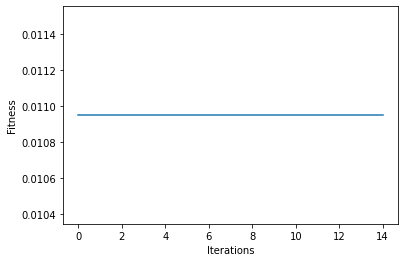

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

Y_history = pd.DataFrame(ga.all_history_Y)
fig, ax = plt.subplots(1, 1)
# ax[0].plot(Y_history.index, Y_history.values, '.', color='red')
Y_history.min(axis=1).cummin().plot(kind='line')
plt.xlabel("Iterations")
plt.ylabel("Fitness")
plt.show()

In [ ]:
Y_history.min(axis=1).cummin()

0     0.010951
1     0.010951
2     0.010951
3     0.010951
4     0.010951
5     0.010951
6     0.010951
7     0.010951
8     0.010951
9     0.010951
10    0.010951
11    0.010951
12    0.010951
13    0.010951
14    0.010951
dtype: float64

## Pile A

### observation data

In [ ]:
# Pile A
# experimental data: SC and DC BC respectively
F_res = np.array([530.82,1035.96, 1549.66,2063.36, 2577.05,3099.32, 3621.58, 4101.03,4597.60,5136.99])
n = np.linspace(1,F_res.shape[0],F_res.shape[0])
L = 3.763
C_ph_res_s = 2*L*F_res/(n-0.5)
C_ph_res_d = 2*L*F_res/(n)

In [ ]:
F_res.shape[0]

10

In [ ]:
n

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [ ]:
fn = F_res
E = 18773059558.275; # Young’s modulus
cb = 3863
rho = E/cb**2;# density
print("rho",rho)
vv = 0.2 # poisson's ratio
r = 0.249/2
m = 0 # Longitudinal
dpr = DPR(fn,E,rho,vv,r,m)
K_exp = dpr.run()

rho 1258.0144849977241


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/scipy/optimize/zeros.py:650: ComplexWarning: Casting complex valu

#### Experimental and theoretical phase velocity

Text(0, 0.5, 'Phase velocity(m/s)')

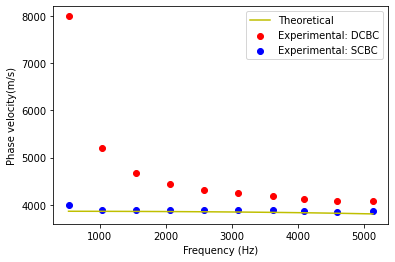

In [ ]:
import numpy as np
np.set_printoptions(threshold=np.inf)
f1 = F_res
plt.plot(f1,np.array(K_exp),label = 'Theoretical',c = 'y')
plt.scatter(f1,C_ph_res_s,label = 'Experimental: DCBC',c = 'red')
plt.scatter(f1,C_ph_res_d,label = 'Experimental: SCBC',c = 'blue')
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase velocity(m/s)")

### GA for inversion

In [ ]:
import numpy as np
from sko.GA import GA, GA_TSP
fn = np.array(F_res) # experimental resonance frequency
n = n # resonance number

def demo_func(x):
    L,En,rho_n,vv = x
    dpr = DPR(fn,En*1e9,rho_n*1e3,vv,r)
    d_temp = dpr.run()
    fitness_d = np.abs(np.mean(d_temp/(2*L)-fn/(n)))**2 # the fitness using the displacement control boundary condition
    fitness_s = np.abs(np.mean(d_temp/(2*L)-fn/(n-1/2)))**2 # the fitness using the stress control boundary condition
    # Loss = fitness_d
    Loss = fitness_s
    return Loss

In [ ]:
# The are: Length L, E youbg's modulus, rho density, Poissio's ratio, vv respectively
Real =  np.array([L,E/1e9,rho/1e3,vv])
Real

array([ 3.763     , 18.77305956,  1.25801448,  0.2       ])

In [ ]:
ga = GA(func=demo_func, n_dim= 4, size_pop= 20, max_iter= 15, prob_mut=0.05,
        lb=[3, 15, 1, 0.18], ub=[4.5, 20, 1.5, 0.22], precision=[0.1, 0.1, 0.1,0.01])

In [ ]:
Res = ga.run()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/scipy/optimize/zeros.py:650: ComplexWarning: Casting complex valu

#### Inversion error

In [ ]:
# The are: Length L, E youbg's modulus, rho density, Poissio's ratio, vv respectively
Real =  np.array([L,E/1e9,rho/1e3,vv])
print("Real value of L,E,rho,vv",Real)
Res_Est = Res[0]
print("Estimated value of L,E,rho,vv",Res_Est)
error_rate_fun(Real,Res_Est)

Real value of L,E,rho,vv [ 3.763      18.77305956  1.25801448  0.2       ]
Estimated value of L,E,rho,vv [ 3.         18.41269841  1.28571429  0.18571429]
L_error 0.20276375232527236
E_error 0.019195653455312562
rho_error -0.022018665958851442
vv_error 0.07142857142857145
bar velocity: Cb_error -0.02037067529977276
shear velocity: cs_error -0.028586588413251787
longitudinal velocity: cp_error -0.014486962790871681


#### Fitness record display

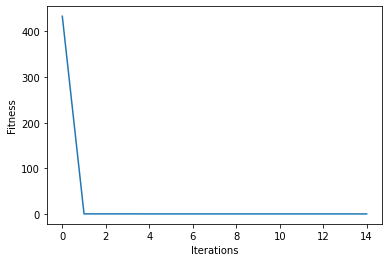

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

Y_history = pd.DataFrame(ga.all_history_Y)
fig, ax = plt.subplots(1, 1)
# ax[0].plot(Y_history.index, Y_history.values, '.', color='red')
Y_history.min(axis=1).cummin().plot(kind='line')
plt.xlabel("Iterations")
plt.ylabel("Fitness")
plt.show()

In [ ]:
Y_history.min(axis=1).cummin()

0     433.052129
1       0.415596
2       0.415596
3       0.415596
4       0.299769
5       0.299769
6       0.299769
7       0.299769
8       0.299769
9       0.299769
10      0.299769
11      0.299769
12      0.299769
13      0.299769
14      0.299769
dtype: float64

## Pile B

### observation data

In [ ]:
# Pile B
# experimental data: SC and DC BC respectively
F_res = np.array([393.84,779.11,  1172.95, 1515.41,  1934.93,2294.52,  2696.92, 3073.63,3441.78, 3878.42,4238.01,4691.78,5051.37])
n = np.linspace(1,F_res.shape[0],F_res.shape[0])
L = 5.011
C_ph_res_s = 2*L*F_res/(n-0.5)
C_ph_res_d = 2*L*F_res/(n)

In [ ]:
F_res.shape[0]

13

In [ ]:
n

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.])

In [ ]:
fn = F_res
E = 18773059558.275; # Young’s modulus
cb = 3865
rho = E/cb**2;# density
print("rho",rho)
vv = 0.2 # poisson's ratio
r = 0.248/2
m = 0 # Longitudinal
dpr = DPR(fn,E,rho,vv,r,m)
K_exp = dpr.run()

rho 1256.712866373013


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/scipy/optimize/zeros.py:650: ComplexWarning: Casting complex valu

#### Experimental and theoretical phase velocity

Text(0, 0.5, 'Phase velocity(m/s)')

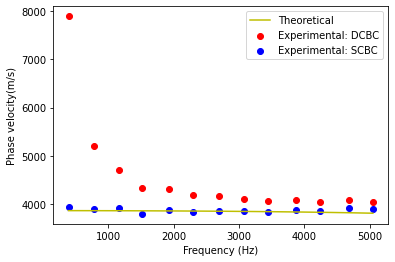

In [ ]:
import numpy as np
np.set_printoptions(threshold=np.inf)
f1 = F_res
plt.plot(f1,np.array(K_exp),label = 'Theoretical',c = 'y')
plt.scatter(f1,C_ph_res_s,label = 'Experimental: DCBC',c = 'red')
plt.scatter(f1,C_ph_res_d,label = 'Experimental: SCBC',c = 'blue')
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase velocity(m/s)")

### GA for inversion

In [ ]:
import numpy as np
from sko.GA import GA, GA_TSP
fn = np.array(F_res) # experimental resonance frequency
n = n # resonance number

def demo_func(x):
    L,En,rho_n,vv = x
    dpr = DPR(fn,En*1e9,rho_n*1e3,vv,r)
    d_temp = dpr.run()
    fitness_d = np.abs(np.mean(d_temp/(2*L)-fn/(n)))**2 # the fitness using the displacement control boundary condition
    fitness_s = np.abs(np.mean(d_temp/(2*L)-fn/(n-1/2)))**2 # the fitness using the stress control boundary condition
    # Loss = fitness_d
    Loss = fitness_s
    return Loss

In [ ]:
# The are: Length L, E youbg's modulus, rho density, Poissio's ratio, vv respectively
Real =  np.array([L,E/1e9,rho/1e3,vv])
Real

array([ 5.011     , 18.77305956,  1.25671287,  0.2       ])

In [ ]:
ga = GA(func=demo_func, n_dim= 4, size_pop= 20, max_iter= 15, prob_mut=0.05,
        lb=[4.5, 15, 1, 0.18], ub=[6, 20, 1.5, 0.22], precision=[0.1, 0.1, 0.1,0.01])

In [ ]:
Res = ga.run()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/scipy/optimize/zeros.py:650: ComplexWarning: Casting complex valu

#### Inversion error

In [ ]:
# The are: Length L, E youbg's modulus, rho density, Poissio's ratio, vv respectively
Real =  np.array([L,E/1e9,rho/1e3,vv])
print("Real value of L,E,rho,vv",Real)
Res_Est = Res[0]
print("Estimated value of L,E,rho,vv",Res_Est)
error_rate_fun(Real,Res_Est)

Real value of L,E,rho,vv [ 5.011      18.77305956  1.25671287  0.2       ]
Estimated value of L,E,rho,vv [ 4.6        18.88888889  1.07142857  0.20285714]
L_error 0.08201955697465585
E_error -0.006169976196705318
rho_error 0.14743566323084506
vv_error -0.01428571428571418
bar velocity: Cb_error 0.0863558216295061
shear velocity: cs_error 0.0883203731513805
longitudinal velocity: cp_error 0.08506484574668771


#### Fitness record display

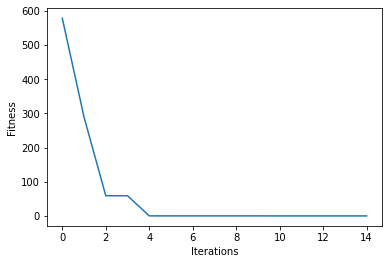

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

Y_history = pd.DataFrame(ga.all_history_Y)
fig, ax = plt.subplots(1, 1)
# ax[0].plot(Y_history.index, Y_history.values, '.', color='red')
Y_history.min(axis=1).cummin().plot(kind='line')
plt.xlabel("Iterations")
plt.ylabel("Fitness")
plt.show()

In [ ]:
Y_history.min(axis=1).cummin()

0     578.557142
1     289.146993
2      59.076948
3      59.076948
4       0.126414
5       0.126414
6       0.126414
7       0.126414
8       0.126414
9       0.094292
10      0.000010
11      0.000010
12      0.000010
13      0.000010
14      0.000010
dtype: float64

## Pile D

### observation data

In [ ]:
# Pile D
# experimental data: SC and DC BC respectively
# F_res = np.array([58.50, 109.20,171.60, 230.10, 271.50, 335.40, 395.85,497.25,629.85,686.40,742.95,859.95,973.05,1004.25])
F_res = np.array([58.50, 109.20,171.60, 230.10, 271.50, 335.40, 395.85,497.25,629.85,686.40,742.95])
# n = np.array([1,2,3,4,5,6,7,9,11,12,13,15,17,18])
n = np.array([1,2,3,4,5,6,7,9,11,12,13])
L = 31.80
C_ph_res_s = 2*L*F_res/(n-0.5)
C_ph_res_d = 2*L*F_res/(n)

In [ ]:
F_res.shape[0]

11

In [ ]:
n

array([ 1,  2,  3,  4,  5,  6,  7,  9, 11, 12, 13])

In [ ]:
fn = F_res
E = 18773059558.275; # Young’s modulus
cb = 3833
rho = E/cb**2;# density
print("rho",rho)
vv = 0.15 # poisson's ratio
r = 1.5/2
m = 0 # Longitudinal
dpr = DPR(fn,E,rho,vv,r,m)
K_exp = dpr.run()

rho 1277.7839226987762


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/scipy/optimize/zeros.py:650: ComplexWarning: Casting complex valu

#### Experimental and theoretical phase velocity

Text(0, 0.5, 'Phase velocity(m/s)')

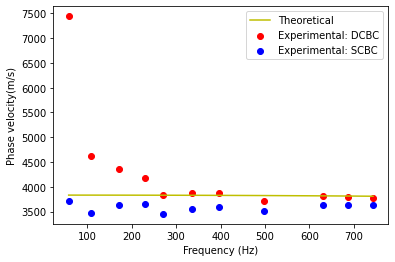

In [ ]:
import numpy as np
np.set_printoptions(threshold=np.inf)
f1 = F_res
plt.plot(f1,np.array(K_exp),label = 'Theoretical',c = 'y')
plt.scatter(f1,C_ph_res_s,label = 'Experimental: DCBC',c = 'red')
plt.scatter(f1,C_ph_res_d,label = 'Experimental: SCBC',c = 'blue')
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase velocity(m/s)")

### GA for inversion

In [ ]:
import numpy as np
from sko.GA import GA, GA_TSP
fn = np.array(F_res) # experimental resonance frequency
n = n # resonance number

def demo_func(x):
    L,En,rho_n,vv = x
    dpr = DPR(fn,En*1e9,rho_n*1e3,vv,r)
    d_temp = dpr.run()
    fitness_d = np.abs(np.mean(d_temp/(2*L)-fn/(n)))**2 # the fitness using the displacement control boundary condition
    fitness_s = np.abs(np.mean(d_temp/(2*L)-fn/(n-1/2)))**2 # the fitness using the stress control boundary condition
    # Loss = fitness_d
    Loss = fitness_s
    return Loss

In [ ]:
# The are: Length L, E youbg's modulus, rho density, Poissio's ratio, vv respectively
Real =  np.array([L,E/1e9,rho/1e3,vv])
Real

array([31.8       , 18.77305956,  1.27778392,  0.15      ])

In [ ]:
ga = GA(func=demo_func, n_dim= 4, size_pop= 20, max_iter= 15, prob_mut=0.05,
        lb=[28, 15, 1, 0.12], ub=[33, 20, 1.5, 0.18], precision=[0.1, 0.1, 0.1,0.01])

In [ ]:
Res = ga.run()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/scipy/optimize/zeros.py:650: ComplexWarning: Casting complex valu

#### Inversion error

In [ ]:
# The are: Length L, E youbg's modulus, rho density, Poissio's ratio, vv respectively
Real =  np.array([L,E/1e9,rho/1e3,vv])
print("Real value of L,E,rho,vv",Real)
Res_Est = Res[0]
print("Estimated value of L,E,rho,vv",Res_Est)
error_rate_fun(Real,Res_Est)

Real value of L,E,rho,vv [31.8        18.77305956  1.27778392  0.15      ]
Estimated value of L,E,rho,vv [30.3015873  19.28571429  1.14285714  0.18      ]
L_error 0.047119896176500004
E_error -0.02730800090672006
rho_error 0.10559436336987073
vv_error -0.2
bar velocity: Cb_error 0.07172428418699334
shear velocity: cs_error 0.08679463132062383
longitudinal velocity: cp_error 0.05801296110157993


#### Fitness record display

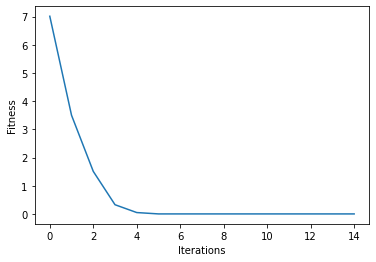

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

Y_history = pd.DataFrame(ga.all_history_Y)
fig, ax = plt.subplots(1, 1)
# ax[0].plot(Y_history.index, Y_history.values, '.', color='red')
Y_history.min(axis=1).cummin().plot(kind='line')
plt.xlabel("Iterations")
plt.ylabel("Fitness")
plt.show()

In [ ]:
Y_history.min(axis=1).cummin()

0     7.014700
1     3.500649
2     1.509317
3     0.326433
4     0.048533
5     0.000213
6     0.000213
7     0.000213
8     0.000213
9     0.000213
10    0.000213
11    0.000213
12    0.000133
13    0.000133
14    0.000133
dtype: float64

## Pile E

### observation data

In [ ]:
# Pile E
# experimental data: SC and DC BC respectively
F_res = np.array([89.84,187.50,265.63,355.47,453.13,527.34,617.19,734.38])
n = np.linspace(1,F_res.shape[0],F_res.shape[0])
L = 19.48
C_ph_res_s = 2*L*F_res/(n-0.5)
C_ph_res_d = 2*L*F_res/(n)

In [ ]:
F_res.shape[0]

8

In [ ]:
n

array([1., 2., 3., 4., 5., 6., 7., 8.])

In [ ]:
fn = F_res
E = 18773059558.275; # Young’s modulus
cb = 3643
rho = E/cb**2;# density
print("rho",rho)
vv = 0.2 # poisson's ratio
r = 1/2
m = 0 # Longitudinal
dpr = DPR(fn,E,rho,vv,r,m)
K_exp = dpr.run()

rho 1414.5448291497787


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/scipy/optimize/zeros.py:650: ComplexWarning: Casting complex valu

#### Experimental and theoretical phase velocity

Text(0, 0.5, 'Phase velocity(m/s)')

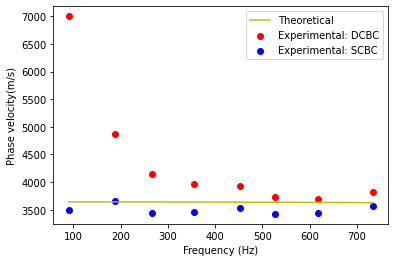

In [ ]:
import numpy as np
np.set_printoptions(threshold=np.inf)
f1 = F_res
plt.plot(f1,np.array(K_exp),label = 'Theoretical',c = 'y')
plt.scatter(f1,C_ph_res_s,label = 'Experimental: DCBC',c = 'red')
plt.scatter(f1,C_ph_res_d,label = 'Experimental: SCBC',c = 'blue')
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase velocity(m/s)")

### GA for inversion

In [ ]:
import numpy as np
from sko.GA import GA, GA_TSP
fn = np.array(F_res) # experimental resonance frequency
n = n # resonance number

def demo_func(x):
    L,En,rho_n,vv = x
    dpr = DPR(fn,En*1e9,rho_n*1e3,vv,r)
    d_temp = dpr.run()
    fitness_d = np.abs(np.mean(d_temp/(2*L)-fn/(n)))**2 # the fitness using the displacement control boundary condition
    fitness_s = np.abs(np.mean(d_temp/(2*L)-fn/(n-1/2)))**2 # the fitness using the stress control boundary condition
    # Loss = fitness_d
    Loss = fitness_s
    return Loss

In [ ]:
# The are: Length L, E youbg's modulus, rho density, Poissio's ratio, vv respectively
Real =  np.array([L,E/1e9,rho/1e3,vv])
Real

array([19.48      , 18.77305956,  1.41454483,  0.2       ])

In [ ]:
ga = GA(func=demo_func, n_dim= 4, size_pop= 20, max_iter= 15, prob_mut=0.05,
        lb=[18, 15, 1, 0.18], ub=[22, 20, 1.5, 0.22], precision=[0.1, 0.1, 0.1,0.01])

In [ ]:
Res = ga.run()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/scipy/optimize/zeros.py:650: ComplexWarning: Casting complex valu

#### Inversion error

In [ ]:
# The are: Length L, E youbg's modulus, rho density, Poissio's ratio, vv respectively
Real =  np.array([L,E/1e9,rho/1e3,vv])
print("Real value of L,E,rho,vv",Real)
Res_Est = Res[0]
print("Estimated value of L,E,rho,vv",Res_Est)
error_rate_fun(Real,Res_Est)

Real value of L,E,rho,vv [19.48       18.77305956  1.41454483  0.2       ]
Estimated value of L,E,rho,vv [18.38095238 19.68253968  1.14285714  0.18571429]
L_error 0.05641928229197232
E_error -0.04844602561673499
rho_error 0.19206721532885987
vv_error 0.07142857142857145
bar velocity: Cb_error 0.1391618261495775
shear velocity: cs_error 0.12960795271004893
longitudinal velocity: cp_error 0.14600370043527236


#### Fitness record display

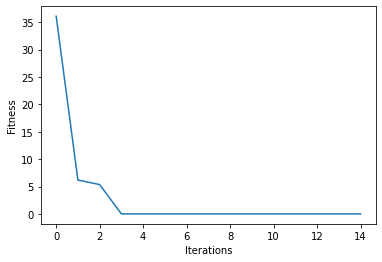

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

Y_history = pd.DataFrame(ga.all_history_Y)
fig, ax = plt.subplots(1, 1)
# ax[0].plot(Y_history.index, Y_history.values, '.', color='red')
Y_history.min(axis=1).cummin().plot(kind='line')
plt.xlabel("Iterations")
plt.ylabel("Fitness")
plt.show()

In [ ]:
Y_history.min(axis=1).cummin()

0     36.068604
1      6.181504
2      5.353480
3      0.001010
4      0.000601
5      0.000601
6      0.000601
7      0.000601
8      0.000601
9      0.000601
10     0.000601
11     0.000601
12     0.000601
13     0.000601
14     0.000601
dtype: float64